### Hypothesis: Cryptocurrency Bitcoin correlate with Ripple
##### Along with interpretations and analysis across different coins
<hr>

In [158]:
import requests
import pandas as pd
import numpy as np
import webbrowser
from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

## Task 1: Identify web API to pull data

- CryptoCurrency API : https://min-api.cryptocompare.com/


- Selected the API from CryptoCompare which allows to fetch all cryptocurrency related data.
- Using this API we can pull opening, closing, high, low prices and other parameters for each cryptocurrency including its historical data.
- The API provide data for 4500+ coins.
- No API key required to pull the data
- It returns JSON data with the following parameters:





In [12]:
# Sample JSON pull with the details on different parameters which are available via the API for each cryptocurrency
sample = requests.get("https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=1")
sample.json()

{'Aggregated': False,
 'ConversionType': {'conversionSymbol': '', 'type': 'direct'},
 'Data': [{'close': 8911.35,
   'high': 9184.51,
   'low': 8778.69,
   'open': 8920.53,
   'time': 1521590400,
   'volumefrom': 109985.22,
   'volumeto': 991376396.96},
  {'close': 8718.63,
   'high': 9107,
   'low': 8646.57,
   'open': 8911.37,
   'time': 1521676800,
   'volumefrom': 56980.46,
   'volumeto': 507380012.45}],
 'FirstValueInArray': True,
 'Response': 'Success',
 'TimeFrom': 1521590400,
 'TimeTo': 1521676800,
 'Type': 100}

## Task 2: Pull JSON data from API

Created a function which accepts the parameters as a list of names of Cryptocurrencies and the actual currency to display their cost in<br><br>
It pulls the data for each Cryptocurrencies, convert JSON to dataframe and keep on appending to a dataframe along with a new column with the details of the name of Cryptocurrencies to which data belongs to.

<b>Parameters:</b>
- <b>name:</b> Accept a list of cryptocurrency codes
- <b>currency:</b> currency used to display the prices. USD, EUR, etc
- <b>limit:</b> Number of last n number of days for which we need to pull the data
- <b>save:</b> If we want to save the pulled data to a file named "crypto_data.csv"

In [9]:
def get_crypto_data(coins=['BTC', 'XRP'], currency='USD',limit=1000, save=None):
    
    # Set initial variables
    data = pd.DataFrame()
    
    # Fetch one coin data at a time
    for coin in coins:
        
        # Set the parameters for the JSON endpoint of our API
        parameters = {"fsym": coin, "tsym": currency, "limit": limit}
        
        # Call the API to fetch the values
        response = requests.get("https://min-api.cryptocompare.com/data/histoday", params=parameters)
        
        # Check if data pull was success of not
        if len(response.json()['Data']) > 0:
            
            # Pull the useful key value pair from JSON which contains the crypto data
            # Add the coin name as a new column and append whole data to an existing dataframe
            crypto_data = pd.DataFrame(response.json()['Data'])
            crypto_data["name"] = coin
            data = pd.concat([data, crypto_data])
        else:
            # If coin does not exist, display the following message
            print("Couldn't find data for : ", coin, "coin")
            
    # Save the data for future use so we don't need to call the API again.
    # Its a parameter which needs to be set then only the file will be saved
    if save:
        data.to_csv("crypto_data.csv", index=False)
        
    # Check if any kind of data is pulled into the dataframe or not for atleast one of the coins
    # Display the message accordingly
    if len(data) > 0:
        print("\nData pull complete...!!!")
    else:
        print("\nData pull failed...Check the Crypto codes passed...!!!")
    
    # return the dataframe with all the pulled data for different coins
    return data
    

## Task 3: Parse the collected data and store it

- Get the cypto codes from the following link for which we need to pull the data : https://www.cryptocompare.com/coins/list/USD/1


- We pass a list of codes of different cryptocurrency as a list which serves as a paramters to our function defining the coins for which we need to pull the data


- Calls the function to pull the data. Use different set of parameters while calling the function as per the need
- Saves the data as csv file

In [10]:
# List of crypto coins codes to be pulled
# If there is any extra code which does not exist, our function will display a message accordingly
# Pull data for Bitcoin, Ethereum, Ripple
pull_coins = ['BTC', 'ETH', 'XRP']

# call the function with the required parameters as described 
# By default this function pulls 1000 days of data in past.
# Saves the data in a file named : crypto_data.csv
data = get_crypto_data(coins=pull_coins, save="Yes")


Data pull complete...!!!


#### JSON to Dataframe

In [15]:
# Overview of how the dataframe looks like
data.head()

,close,high,low,open,time,volumefrom,volumeto,name
0,242.95,243.49,240.14,242.56,1435276800,37617.83,9112156.60,BTC
1,250.73,251.57,241.83,242.95,1435363200,54700.08,13525813.79,BTC
2,248.88,251.59,246.62,250.73,1435449600,39892.18,9955671.92,BTC
3,256.97,257.54,247.96,248.88,1435536000,92643.49,23504772.60,BTC
4,264.12,268.73,255.37,256.97,1435622400,116532.34,30621602.74,BTC


In [20]:
# 1000 days of data from past + 1 day of data for today for each coin
print("Total rows in data: ", len(data))

# Rows per coin
data.name.value_counts()

Total rows in data:  3003


BTC    1001
XRP    1001
ETH    1001
Name: name, dtype: int64

## Task 4: Pre-processing and Quality checks

- After downoading the data and converting it to the dataframe we can do data analysis and exlore it to see find some useful - patterns


- We can do some feature engineering as well to create more variables which can be used for slice and dice in different ways

In [23]:
# Check if we have a null value in any of the columns
data.isnull().sum()

close         0
high          0
low           0
open          0
time          0
volumefrom    0
volumeto      0
name          0
dtype: int64

In [25]:
# Check the data types of different columns
data.dtypes.value_counts() 

float64    6
object     1
int64      1
dtype: int64

#### Feature Engineering

In [29]:
# Convert timestamp to date
data['date'] = pd.to_datetime(data['time'], unit='s')

# Create date as the index for our dataframe
data.index = data['date']

# Extract year and month and create extra columns. Could be useful for aggregation purposes
data['year'] = pd.DatetimeIndex(data['date']).year
data['month'] = pd.DatetimeIndex(data['date']).month

# Append an extra '0' to single digit months. 1,2,3 -> 01, 02, 03
data['month'] = data['month'].map("{:02}".format)

# Concat Year and month and create a new column
data['period'] = data[['year', 'month']].astype(str).apply(lambda x: '-'.join(x), axis=1)

# Create the fluctuation metric to see the difference within a day 
data['fluctuation'] = data['high'] - data['low']
data.head()

,close,high,low,open,time,volumefrom,volumeto,name,date,year,month,period,fluctuation
date,,,,,,,,,,,,,
2015-06-26,242.95,243.49,240.14,242.56,1435276800,37617.83,9112156.60,BTC,2015-06-26,2015,06,2015-06,3.35
2015-06-27,250.73,251.57,241.83,242.95,1435363200,54700.08,13525813.79,BTC,2015-06-27,2015,06,2015-06,9.74
2015-06-28,248.88,251.59,246.62,250.73,1435449600,39892.18,9955671.92,BTC,2015-06-28,2015,06,2015-06,4.97
2015-06-29,256.97,257.54,247.96,248.88,1435536000,92643.49,23504772.60,BTC,2015-06-29,2015,06,2015-06,9.58
2015-06-30,264.12,268.73,255.37,256.97,1435622400,116532.34,30621602.74,BTC,2015-06-30,2015,06,2015-06,13.36


#### Get a summary of the data.
A maximum fluctuation of $5000 can be observed which shows these prices are very volatile.

In [30]:
# Describe the columns of the data to get the five point summary and other extra details.
# Transpose it to make it easily readable
data.describe().T

,count,mean,std,min,25%,50%,75%,max
close,3003.0,9.152704e+02,2.525174e+03,0.000000e+00,1.752500e-01,1.196000e+01,5.666950e+02,1.934549e+04
high,3003.0,9.503755e+02,2.639303e+03,0.000000e+00,1.843000e-01,1.230000e+01,5.777300e+02,1.987062e+04
low,3003.0,8.678042e+02,2.370478e+03,0.000000e+00,1.647000e-01,1.156000e+01,5.346150e+02,1.875091e+04
open,3003.0,9.122660e+02,2.521236e+03,0.000000e+00,1.746000e-01,1.196000e+01,5.631750e+02,1.934660e+04
time,3003.0,1.478477e+09,2.497062e+07,1.435277e+09,1.456877e+09,1.478477e+09,1.500077e+09,1.521677e+09
volumefrom,3003.0,1.564466e+07,6.680575e+07,0.000000e+00,3.788576e+04,1.052584e+05,5.342170e+05,1.068869e+09
volumeto,3003.0,1.524505e+08,4.157173e+08,0.000000e+00,9.204660e+03,1.284194e+07,8.294024e+07,6.245732e+09
year,3003.0,2.016338e+03,8.737055e-01,2.015000e+03,2.016000e+03,2.016000e+03,2.017000e+03,2.018000e+03
fluctuation,3003.0,8.257123e+01,3.100103e+02,0.000000e+00,9.520000e-03,1.020000e+00,2.185500e+01,4.948010e+03


In [31]:
# Get the unique list of the coins for which we have pulled the data
data.name.unique()

array(['BTC', 'ETH', 'XRP'], dtype=object)

#### Filter rows and columns for the analysis

In [34]:
# Filter for the coins which we want to analyze
analyze_coin = ['BTC', 'ETH', 'XRP']
df = data[data['name'].isin(analyze_coin)]

# Filter by year. We will consider data from 2016 onwards
year_filter = [2016, 2017, 2018]
df = df[df.year.isin(year_filter)]

# Sort values by date column if required
# df = df.sort_values(by=['date'])

# List of columns we want to keep for further analysis
keep_columns = ['close', 'high', 'low', 'open', 'name']
df = df[keep_columns]

# Show a sample of what we will be working with
df.head()

,close,high,low,open,name
date,,,,,
2016-01-01,433.99,437.95,425.86,429.95,BTC
2016-01-02,433.72,437.43,430.73,433.99,BTC
2016-01-03,430.70,434.14,423.09,433.72,BTC
2016-01-04,433.32,435.26,428.60,430.70,BTC
2016-01-05,431.20,435.25,428.87,433.32,BTC


#### Create a pivot of the dataframe 
- Change its shape by bringing the currency 'name' column in the column index and display split across this.
- This method will be useful to create the charts later as we can plot different currency plot against each other.

In [36]:
# Create data pivot 
df_pivot = df.pivot(columns='name')
df_pivot.head()

close                      high                       low  \
name           BTC     ETH       XRP     BTC     ETH       XRP     BTC   
date                                                                     
2016-01-01  433.99  0.9200  0.005500  437.95  0.9488  0.005500  425.86   
2016-01-02  433.72  0.9547  0.005125  437.43  0.9547  0.005132  430.73   
2016-01-03  430.70  0.9600  0.005200  434.14  0.9700  0.005400  423.09   
2016-01-04  433.32  0.9500  0.005100  435.26  0.9644  0.005350  428.60   
2016-01-05  431.20  0.9426  0.005000  435.25  0.9599  0.005400  428.87   

                                open                    
name           ETH       XRP     BTC     ETH       XRP  
date                                                    
2016-01-01  0.9184  0.005132  429.95  0.9488  0.005205  
2016-01-02  0.9200  0.005000  433.99  0.9200  0.005132  
2016-01-03  0.9506  0.005000  433.72  0.9547  0.005125  
2016-01-04  0.9186  0.005100  430.70  0.9600  0.005200  
2016-01-05  0.9409  0.005000  433.32  0.9500  0.005100

In [56]:
# Switch the multi index in columns and arrange dataframe by category of crypto currency
df_pivot.columns = df_pivot.columns.swaplevel(0, 1)
df_pivot.sort_index(level=0, axis=1, inplace=True)
df_pivot.head()

name           BTC                             ETH                          \
             close    high     low    open   close    high     low    open   
date                                                                         
2016-01-01  433.99  437.95  425.86  429.95  0.9200  0.9488  0.9184  0.9488   
2016-01-02  433.72  437.43  430.73  433.99  0.9547  0.9547  0.9200  0.9200   
2016-01-03  430.70  434.14  423.09  433.72  0.9600  0.9700  0.9506  0.9547   
2016-01-04  433.32  435.26  428.60  430.70  0.9500  0.9644  0.9186  0.9600   
2016-01-05  431.20  435.25  428.87  433.32  0.9426  0.9599  0.9409  0.9500   

name             XRP                                
               close      high       low      open  
date                                                
2016-01-01  0.005500  0.005500  0.005132  0.005205  
2016-01-02  0.005125  0.005132  0.005000  0.005132  
2016-01-03  0.005200  0.005400  0.005000  0.005125  
2016-01-04  0.005100  0.005350  0.005100  0.005200  
2016-01-05  0.005000  0.005400  0.005000  0.005100

In [44]:
# Aggregate the data per month and get the mean values related to it
df_month = df_pivot.groupby([pd.Grouper(freq='M')]).mean()
df_month.head()

name               BTC                                            ETH  \
                 close        high         low        open      close   
date                                                                    
2016-01-31  410.942581  419.301935  401.927419  412.881613   1.488945   
2016-02-29  403.789655  408.631034  396.320690  401.501034   4.515172   
2016-03-31  414.957097  419.267742  410.085806  415.620000  11.137742   
2016-04-30  433.446667  436.389000  428.483000  432.351000   8.954667   
2016-05-31  461.351613  466.723226  453.341290  458.758387  11.288710   

name                                              XRP                      \
                 high        low       open     close      high       low   
date                                                                        
2016-01-31   1.595252   1.337203   1.448584  0.005260  0.005625  0.005031   
2016-02-29   4.844483   3.955517   4.372069  0.007862  0.011329  0.007457   
2016-03-31  11.859032   9.968065  10.974516  0.007966  0.008349  0.007736   
2016-04-30   9.416667   8.540667   9.040667  0.006858  0.007057  0.006621   
2016-05-31  11.777742  10.656774  11.126774  0.006011  0.006186  0.005866   

name                  
                open  
date                  
2016-01-31  0.005265  
2016-02-29  0.007812  
2016-03-31  0.007996  
2016-04-30  0.006872  
2016-05-31  0.006047

### One major issue using this data is the currency price scale has a vast difference 
- Bitcoin : 1000 - 20000
- Etherum : 200 - 1500
- Ripple : 0.1 - 4
- So on

In [62]:
# Filter the column 'close' for each coin. Filter at level 1 of index in multi column index
scale_check1 = df_pivot.iloc[:, df_pivot.columns.get_level_values(1)=='close']

# Drop the index level 1
scale_check1.columns = scale_check1.columns.droplevel(1)

#### We can observe below the difference in scales which makes it impossible to compare the currency relation among each other.
- We can use the secondary axis for plotting but if we want to compare more than 2 currencies, the issue remains the same

<b>Analysis:</b> Hard to compare currencies because of difference price ranges ( Solution ahead )

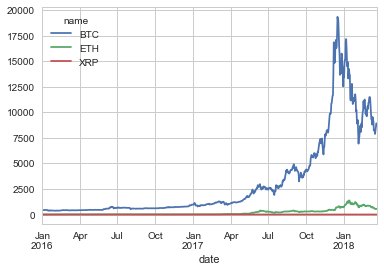

In [63]:
# Plot the graph for closing price of different coins
scale_check1.plot()

#### To solve this issue we need to normalize our data to get all these values on similar scale so they can be compared against each other.
- We will normalize our data between the range of 1 to 10 just to have a good spread among them
- Could have gone with a range of 0-1 and that wouldn't have made a major difference.

In [65]:
# Call the normalization function
scaler = MinMaxScaler(feature_range=(1, 10))

# Fit our dataframe
df_pivot_scaled = pd.DataFrame(scaler.fit_transform(df_pivot))

# Copy the column and row index from one dataframe to another
df_pivot_scaled.columns = df_pivot.columns
df_pivot_scaled.index = df_pivot.index

# Display normalized dataframe
df_pivot_scaled.head()

name             BTC                                     ETH            \
               close      high       low      open     close      high   
date                                                                     
2016-01-01  1.031286  1.028651  1.036914  1.029368  1.000000  1.000000   
2016-01-02  1.031158  1.028411  1.039296  1.031284  1.000226  1.000037   
2016-01-03  1.029726  1.026892  1.035559  1.031156  1.000260  1.000134   
2016-01-04  1.030968  1.027409  1.038254  1.029724  1.000195  1.000099   
2016-01-05  1.029963  1.027404  1.038386  1.030966  1.000147  1.000070   

name                                 XRP                                
                 low      open     close      high       low      open  
date                                                                    
2016-01-01  1.000000  1.000187  1.004863  1.001597  1.007446  1.003874  
2016-01-02  1.000011  1.000000  1.003647  1.000589  1.006985  1.003638  
2016-01-03  1.000228  1.000226  1.003890  1.001323  1.006985  1.003615  
2016-01-04  1.000001  1.000260  1.003566  1.001186  1.007334  1.003858  
2016-01-05  1.000159  1.000195  1.003242  1.001323  1.006985  1.003534

In [67]:
# We can observe all the values are in the range of 1-10
df_pivot_scaled.describe()

name          BTC                                             ETH              \
            close        high         low        open       close        high   
count  812.000000  812.000000  812.000000  812.000000  812.000000  812.000000   
mean     2.305430    2.322198    2.275976    2.300511    2.257905    2.280866   
std      1.944393    1.983612    1.874836    1.942563    1.898972    1.941296   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      1.112241    1.107587    1.119051    1.112016    1.063919    1.064379   
50%      1.303665    1.303211    1.307715    1.303611    1.086547    1.087292   
75%      2.776660    2.765611    2.757367    2.770511    2.929366    2.933071   
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   

name                                  XRP                                      
              low        open       close        high         low        open  
count  812.000000  812.000000  812.000000  812.000000  812.000000  812.000000  
mean     2.284389    2.253573    1.675020    1.612320    1.662980    1.672458  
std      1.935133    1.897814    1.366087    1.262960    1.318368    1.365406  
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000  
25%      1.066529    1.063854    1.007937    1.004649    1.011350    1.007886  
50%      1.089327    1.085864    1.013532    1.009667    1.017130    1.013479  
75%      3.035257    2.925854    1.695830    1.624801    1.712631    1.692234  
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000

In [68]:
# Filter the column 'close' for each coin. Filter at level 1 of index in multi column index
scale_check2 = df_pivot_scaled.iloc[:, df_pivot_scaled.columns.get_level_values(1)=='close']

# Drop the index level 1
scale_check2.columns = scale_check2.columns.droplevel(1)

#### Updated graph with normalized data
- Now we can do a proper comparison across the currencies.
- Scale is update to 1 to 10

<b>Analysis:</b> After data scaling, currencies can be compared easily

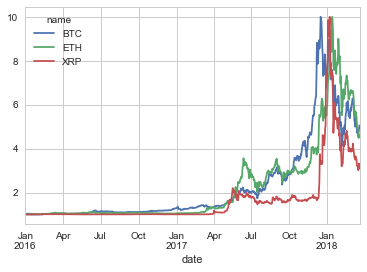

In [69]:
scale_check2.plot()

In [70]:
# Stack the scaled data to get the raw form. ( Although we won't be using this for analysis in this particular example but other wise it can be really helpful)
df_scaled = df_pivot_scaled.stack(0)
df_scaled.reset_index(1, inplace=True)
df_scaled.head()

,name,close,high,low,open
date,,,,,
2016-01-01,BTC,1.031286,1.028651,1.036914,1.029368
2016-01-01,ETH,1.000000,1.000000,1.000000,1.000187
2016-01-01,XRP,1.004863,1.001597,1.007446,1.003874
2016-01-02,BTC,1.031158,1.028411,1.039296,1.031284
2016-01-02,ETH,1.000226,1.000037,1.000011,1.000000


## Task 5: Analyze and create Visualizations

- In this section we will be showcasing how visualizations can be used to analyze and interpret our data easily

<b>Analysis:</b> Shows how bitcoin prices increased drasically over the years

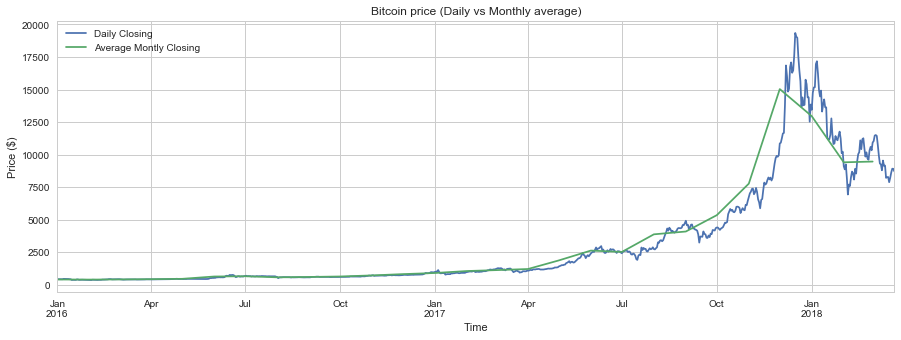

In [90]:
# Display a time series chart showing how price for bitcoin have been changing with time
plt.figure(figsize=(15, 5))
df_pivot.BTC.close.plot(label='Daily Closing')
df_month.BTC.close.plot(label='Average Montly Closing')
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title("Bitcoin price (Daily vs Monthly average)")
plt.legend()
plt.show()

<b>Analysis:</b> Shows the variation/ fluctuation on a daily basis for bitcoin price

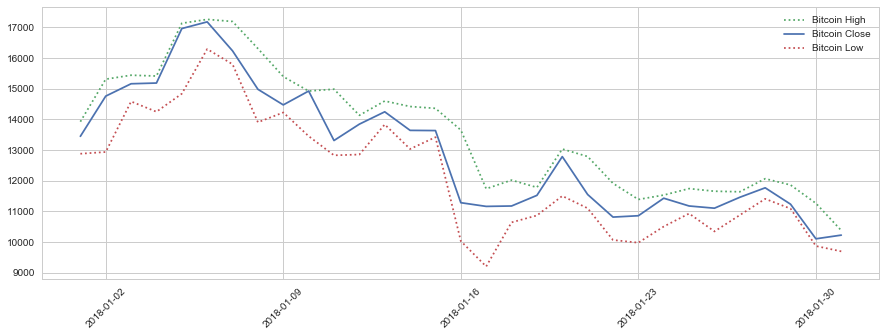

In [88]:
# Visualization displaying daily fluctuation range for bitcoi
# Filter data January 2018
chart1 = df_pivot[(df_pivot.index.year == 2018) & (df_pivot.index.month == 1)]

plt.figure(figsize=(15, 5))
# plt.plot(chart1.BTC.high, 'k:',  chart1.BTC.close, '', chart1.BTC.low, 'k:')
plt.plot(chart1.BTC.high, 'g:', label="Bitcoin High")
plt.plot(chart1.BTC.close, 'b-', label="Bitcoin Close")
plt.plot(chart1.BTC.low, 'r:', label="Bitcoin Low")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [105]:
# Data prep for upcoming charts
chart3 = df
chart3['year'] = df.index.year
chart3['month'] = df.index.month
chart3['period'] = chart3[['year', 'month']].astype(str).apply(lambda x: '-'.join(x), axis=1)
# chart3_1 = chart3[chart3['name']=='BTC']

<b>Analysis:</b> Shows spread of prices for a particular year for all coins

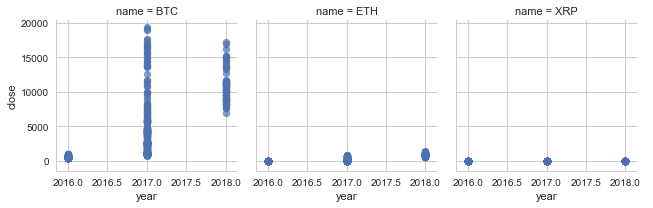

In [106]:
# FacetGrid scatter plot show the spread per year basis 
# This has a lot of overlapping points and its not clear to see which region has most of the points.
# We can use swarm plots to tackle this problem.
g = sns.FacetGrid(chart3, col="name")
g.map(plt.scatter, "year", "close", alpha=.7)
g.add_legend();

# sns.factorplot(x="year", y="close", col="name", data=chart3, kind="box", size=4, aspect=.5);

#### Year level breakdown

<b>Analysis:</b> Shows more details of spread by making sure there is no overlap. Gives a better picture of the distribution of bitcoin pricing over years<br>
<b>Insight:</b> Year 2017 had to most fluctuation. Need to drill down further to get further details

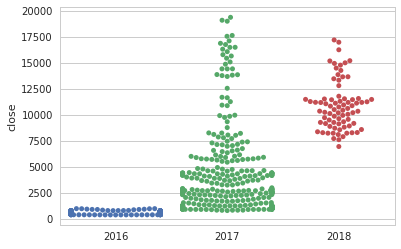

In [52]:
# Use swarmplot to see the spread of prices across year
# We can see in 2017 prices for bitcoin went close to $20000 but remain there only for some time and have remained mostly below or around $5K for most of the year.
sns.swarmplot(x=df_pivot.index.year, y=df_pivot.BTC.close );

#### Quarter Level breakdown

<b>Analysis:</b> Shows details on how bitcoin price varied quaterly over the years<br>
<b>Insight:</b> There have been a 4 fold increase in price in 4th quarter of 2017. We need to drill down further to see which month had the max rise

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

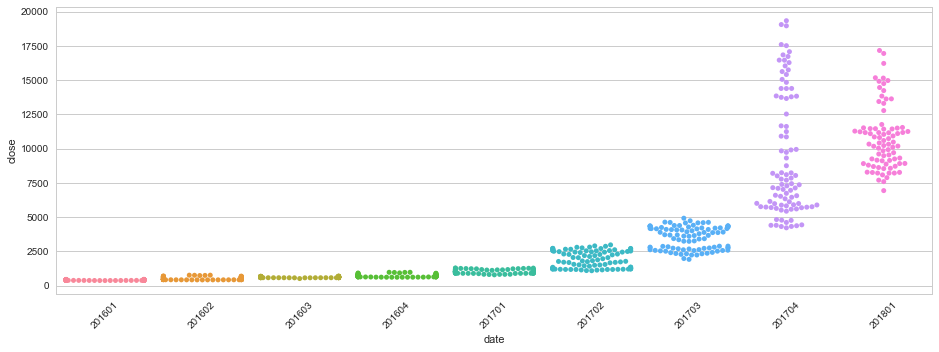

In [109]:
# Create a swarm plot for each quarter 
# Swarm plot show how much a price is varing for bitcoin in each quarter. 
# Swarm plot make sure there are no overlapping points even if the price range remains same.
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 5.27)

y_axis = df_pivot.index.map(lambda x: 100*x.year + x.quarter)
s = sns.swarmplot(x=y_axis, y=df_pivot.BTC.close);
plt.xticks(rotation=45)
# sns.stripplot(x=df_pivot.index.month, y=df_pivot.BTC.close );

#### Monthly level drill down

<b>Analysis:</b> Shows how much bitcoin pricing varied across last few months<br>
<b>Insight:</b> Bitcoin had been increasing drastically from July 2017 onwards and had a peak of $20,000 in Dec 2017

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

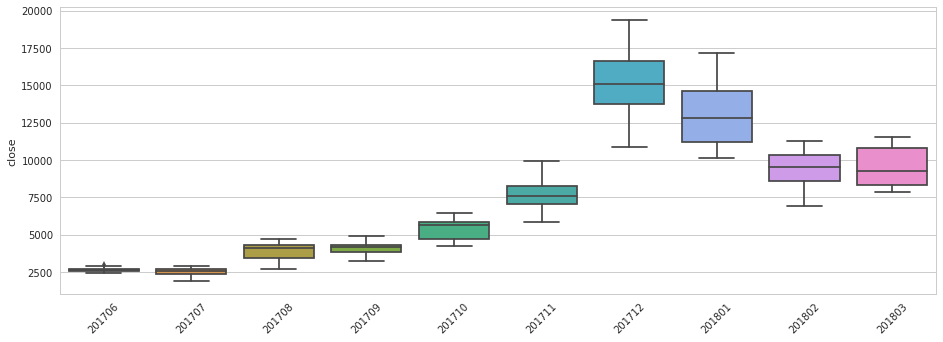

In [51]:
# Get a detailed breakdown at monthly level on how prices are varying each month
# Box plot gives a clear picture on how different quartiles where prices were and the whiskers shows the complete spread
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 5.27)

chart2 = df_pivot[(df_pivot.index > '2017-06-01')]

y_axis = chart2.index.map(lambda x: 100*x.year + x.month)
s = sns.boxplot(x=y_axis, y=chart2.BTC.close );
#s.set_xticklabels(rotation=60)
plt.xticks(rotation=45)
# sns.stripplot(x=df_pivot.index.month, y=df_pivot.BTC.close );

<hr>

#### Compare two coins using secondary axis

In [142]:
# Data prep for comparing two set of currencies
chart4 = df_pivot.iloc[:, df_pivot.columns.get_level_values(1)=='close']
chart4.columns = chart4.columns.droplevel(1)
# ax = chart4.plot(secondary_y=['XRP'])

<b>Analysis:</b> Compare different currencies and see if they correlate with each other<br>
<b>Insight:</b> We can observe Ethereum have more correlation with Bitcoin than Ripple

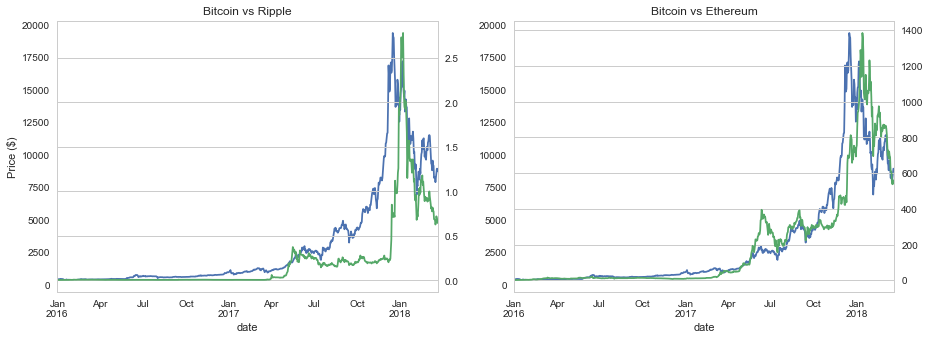

In [140]:
# Use secondary axis to make a comparison across two crypto currency
# Check if they have dependency

plt.figure(1, figsize=(15, 5))

# Bitcoin vs Ripple chart
plt.subplot(121)
chart4.BTC.plot()
plt.ylabel("Price ($)")
chart4.XRP.plot(secondary_y=True)
plt.title("Bitcoin vs Ripple")

# Bitcoin vs Ethereum chart
plt.subplot(122)
chart4.BTC.plot()
chart4.ETH.plot(secondary_y=True)
plt.title("Bitcoin vs Ethereum")

plt.show()

<hr>

#### Compare all three currencies

<b>Analysis:</b> Analyse and compare the 3 currencies

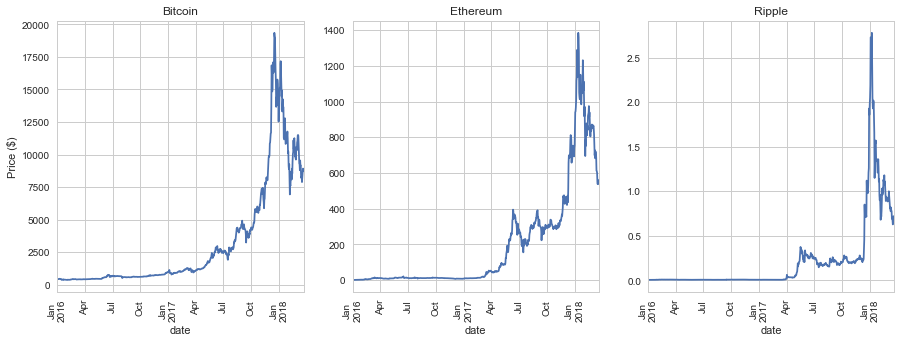

In [79]:
# Time series for each currency with their own y axis scale
plt.figure(1, figsize=(15, 5))
plt.subplot(131)
# plt.plot(df_pivot.BTC.high, 'k:',  df_pivot.BTC.close, '', df_pivot.BTC.low, 'k:')
df_pivot.BTC.close.plot()
plt.xticks(rotation=90)
plt.ylabel("Price ($)")
plt.title("Bitcoin")

plt.subplot(132)
#plt.plot(df_pivot.ETH.high, 'k:',  df_pivot.ETH.close, '', df_pivot.ETH.low, 'k:')
df_pivot.ETH.close.plot()
plt.xticks(rotation=90)
plt.title("Ethereum")

plt.subplot(133)
#plt.plot(df_pivot.ETH.high, 'k:',  df_pivot.ETH.close, '', df_pivot.ETH.low, 'k:')
df_pivot.XRP.close.plot()
plt.xticks(rotation=90)
plt.title("Ripple")

plt.show()

<b>Analysis:</b> Compare different currencies and see if they correlate with each other<br>
<b>Insight:</b> We can observe Ethereum is closer to Bitcoin variation as compared to Ripple

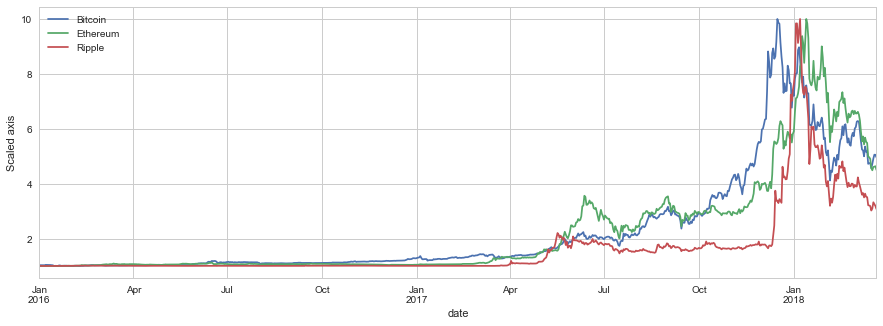

In [156]:
chart5 = df_pivot_scaled.iloc[:, df_pivot_scaled.columns.get_level_values(1)=='close']
plt.figure(figsize=(15, 5))
chart5.BTC.close.plot(label='Bitcoin')
chart5.ETH.close.plot(label='Ethereum')
chart5.XRP.close.plot(label='Ripple')
plt.legend()
plt.ylabel("Scaled axis")

<b>Analysis:</b> Compare different currencies and see if they correlate with each other. Histogram in center displays bin of currency pricing<br>
<b>Insight:</b> We can observe Ethereum have more correlation with Bitcoin than Ripple

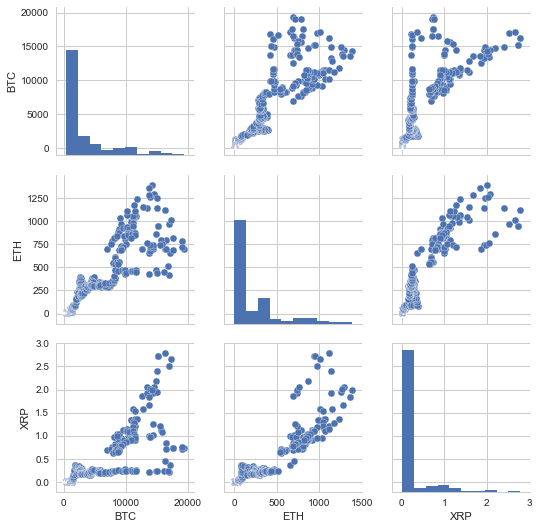

In [141]:
# Use pairplot to compare how different set of currencies are varying and dependent on each other
sns.pairplot(chart4)

<hr>

#### Find what is the correlation between different parameter of coins

In [162]:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corrwith.html
# Correlation: Bitcoin vs Ethereum ( column wise )
df_pivot_scaled.BTC.corrwith(df_pivot_scaled.ETH, axis = 0)

close    0.910924
high     0.910119
low      0.915795
open     0.910799
dtype: float64

In [163]:
# Correlation: Bitcoin vs Ripple ( column wise )
df_pivot_scaled.BTC.corrwith(df_pivot_scaled.XRP, axis = 0)

close    0.826623
high     0.821860
low      0.830366
open     0.826442
dtype: float64

<hr>
### Conclusion

From the above correlation matrix between coins, it can be observed that Ethereum has ~91% correlation with Bitcoin while Ripple has ~82% which is slightly less as compared to Ethereum.<br>
This could possibly mean that bitcoin price controls the pricing of other coins as well.<br><br>
NOTE: Correlation does not mean causation

<hr>
### Further Analysis

We can check if change in bitcoin has impact/ correlation with stock market.
